# Week3: Homography Estimate

In [121]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

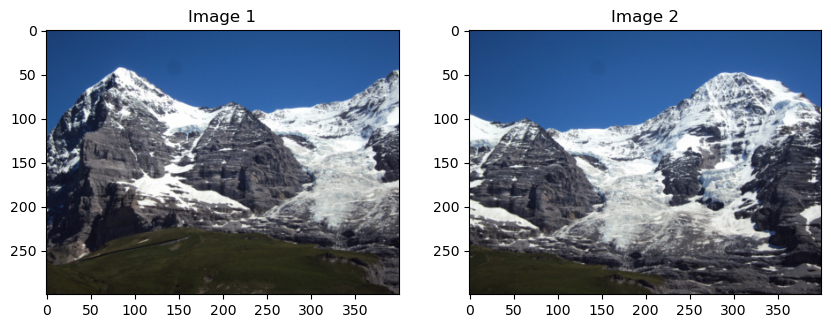

In [122]:
# Load two images
img1 = cv2.imread('resource/hill01.JPG', cv2.IMREAD_COLOR) 
img2 = cv2.imread('resource/hill02.JPG', cv2.IMREAD_COLOR) 

# Display the images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1), plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)), plt.title('Image 1')
plt.subplot(1, 2, 2), plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)), plt.title('Image 2')
plt.show()

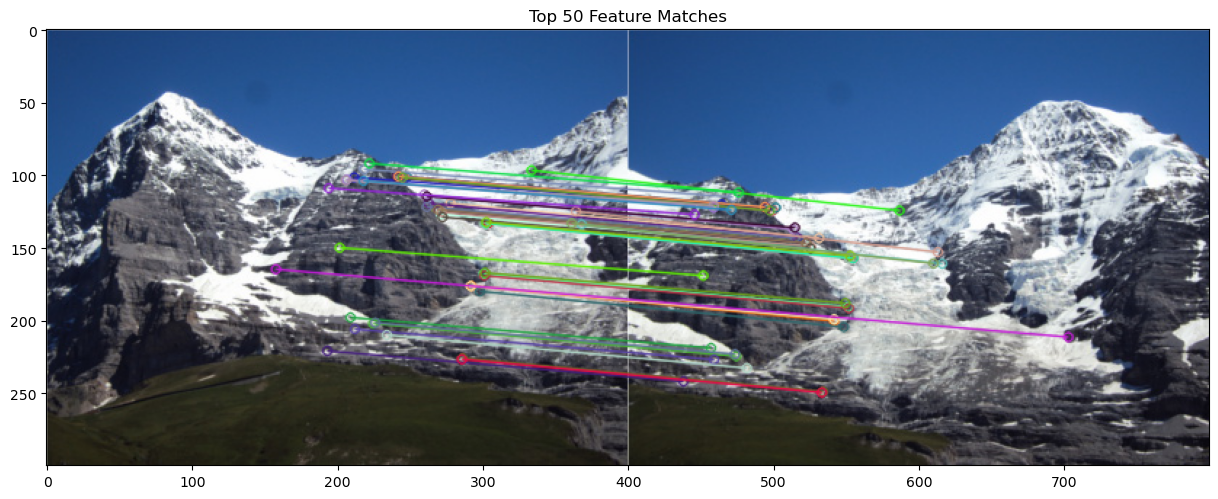

In [123]:
# Initialize ORB detector
orb = cv2.ORB_create()

# Find keypoints and descriptors
keypoints1, descriptors1 = orb.detectAndCompute(img1, None)
keypoints2, descriptors2 = orb.detectAndCompute(img2, None)

# Use BFMatcher for feature matching
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(descriptors1, descriptors2)

# Sort matches by distance
matches = sorted(matches, key=lambda x: x.distance)

# Draw top matches
img_matches = cv2.drawMatches(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB), keypoints1, cv2.cvtColor(img2, cv2.COLOR_BGR2RGB), keypoints2, matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(15, 10))
plt.imshow(img_matches)
plt.title('Top 50 Feature Matches')
plt.show()


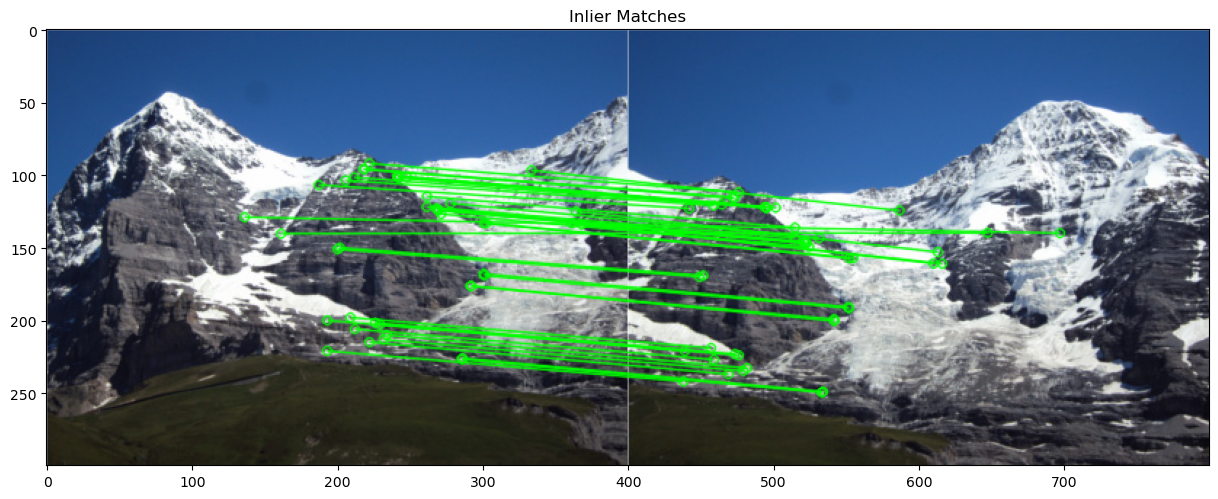

Homography Matrix:
 [[-3.83623414e-06 -5.35231802e-05  7.32720691e-03]
 [ 5.03975040e-05 -2.33469834e-06 -1.95068788e-02]
 [-6.16774784e-03  1.30372274e-02  1.00000000e+00]]


In [124]:
# Extract location of keypoints
src_pts = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

# Compute Homography using RANSAC
H, mask = cv2.findFundamentalMat(src_pts, dst_pts, cv2.RANSAC, 1.0)

# Draw inliers and outliers
matches_mask = mask.ravel().tolist()
draw_params = dict(matchColor=(0, 255, 0),  # Matches in green
                   singlePointColor=None,
                   matchesMask=matches_mask,  # Only draw inliers
                   flags=2)
inlier_matches = cv2.drawMatches(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB), keypoints1, cv2.cvtColor(img2, cv2.COLOR_BGR2RGB), keypoints2, matches, None, **draw_params)

plt.figure(figsize=(15, 10))
plt.imshow(inlier_matches)
plt.title('Inlier Matches')
plt.show()

print("Homography Matrix:\n", H)


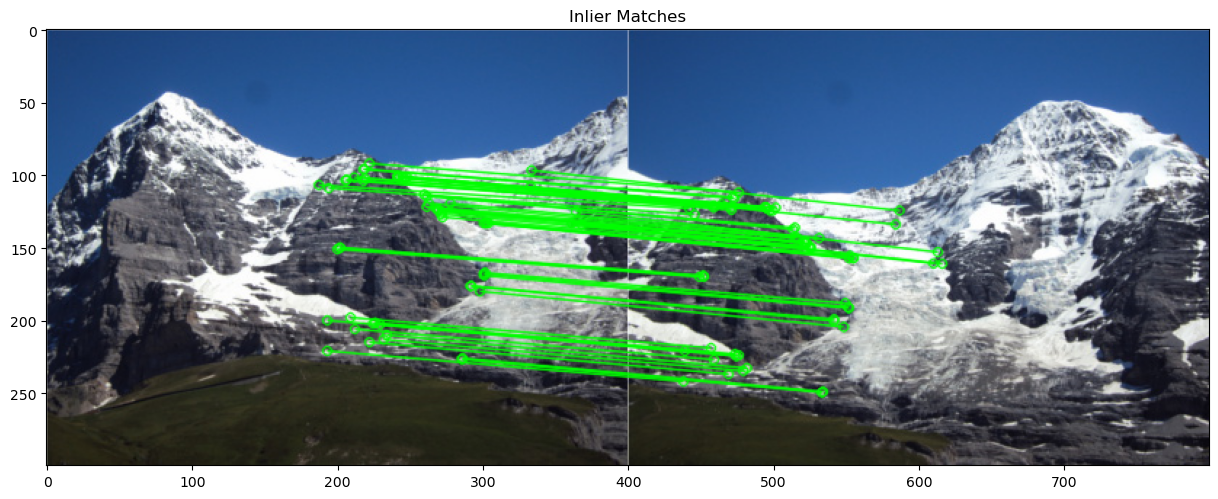

Homography Matrix:
 [[ 1.13508366e+00 -7.19386231e-02 -1.63474708e+02]
 [ 1.19947996e-01  1.05621770e+00 -3.10171201e+00]
 [ 4.15198086e-04 -1.56031161e-04  1.00000000e+00]]


In [125]:
# Extract location of keypoints
src_pts = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

# Compute Homography using RANSAC
H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# Draw inliers and outliers
matches_mask = mask.ravel().tolist()
draw_params = dict(matchColor=(0, 255, 0),  # Matches in green
                   singlePointColor=None,
                   matchesMask=matches_mask,  # Only draw inliers
                   flags=2)
inlier_matches = cv2.drawMatches(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB), keypoints1, cv2.cvtColor(img2, cv2.COLOR_BGR2RGB), keypoints2, matches, None, **draw_params)

plt.figure(figsize=(15, 10))
plt.imshow(inlier_matches)
plt.title('Inlier Matches')
plt.show()

print("Homography Matrix:\n", H)


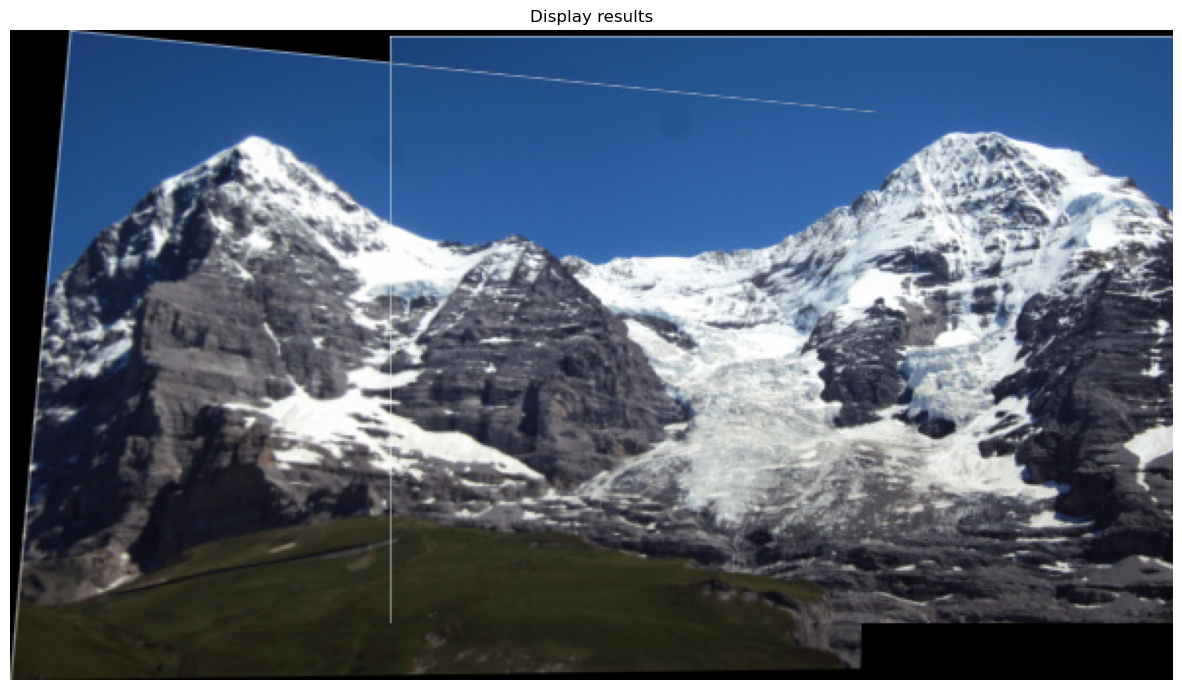

In [126]:
# Get the size of the two images
h1, w1 = img1.shape[:2]
h2, w2 = img2.shape[:2]

# Calculate the four vertices of the projected image
pts_img2 = np.float32([[0, 0], [w2, 0], [w2, h2], [0, h2]]).reshape(-1, 1, 2)
pts_img2_proj = cv2.perspectiveTransform(pts_img2, H)

# Calculate the range of the stitched image
pts_combined = np.vstack(([[0, 0], [w1, 0], [w1, h1], [0, h1]], pts_img2_proj.reshape(-1, 2)))
[x_min, y_min] = np.int32(pts_combined.min(axis=0))
[x_max, y_max] = np.int32(pts_combined.max(axis=0))

# Translation transformation matrix to ensure that the image is in the positive area
translate = np.array([[1, 0, -x_min],
                      [0, 1, -y_min],
                      [0, 0, 1]]).astype(np.float32)

# Update the homography matrix H
H_translate = np.dot(translate, H).astype(np.float32)

# Size of stitched images
output_size = (x_max - x_min, y_max - y_min)

# Translate the first image into the new coordinate system
warped_img1 = cv2.warpPerspective(img1, H_translate, output_size)

# Project the second image
warped_img2 = cv2.warpPerspective(img2, translate, output_size)

# Merge two images
result = np.maximum(warped_img1, warped_img2)

# Display results
plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title("Display results")
plt.axis("off")
plt.show()

In [ ]:
# Class exercise: When merging images, instead of using the maximum function, perform a weighted blending of the overlapping pixels based on the distance from the left and right images.